In [1]:
!pip install kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"singhsaurav701","key":"fb04e458d471765d9d318e959022172f"}'}

In [4]:
!ls

kaggle.json  sample_data


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission 
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d shadabhussain/flickr8k

100% 2.12G/2.13G [00:49<00:00, 45.4MB/s]
100% 2.13G/2.13G [00:49<00:00, 46.0MB/s]


In [7]:
!ls

flickr8k.zip  kaggle.json  sample_data


In [8]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: flickr_data/Flickr_Data/Images/2850719435_221f15e951.jpg  
  inflating: 

In [12]:
!ls

flickr8k.zip  Flickr_Data  model_weights.h5  train_encoded_images.p
flickr_data   kaggle.json  sample_data


###***DATA PREPRPOCESSING***

In [13]:
!pip install segmentation_models

In [14]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import re
import collections
import io
import pandas as pd
import numpy as np
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.models import Model,load_model
from time import time
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import *
from keras.layers.merge import add
from keras.utils import generic_utils
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [15]:
## function to read a file 
def read_file(path):
  with open(path) as f:
    captions = f.read()
  return captions

In [16]:
captions = read_file('/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

In [17]:
captions = captions.split('\n')[:-1]

In [18]:
captions[1].split('\t')[0].split('.')[0]

'1000268201_693b08cb0e'

In [19]:
### We will store the caption of image in a dictionary
desc = {}
for x in captions:
  first,second = x.split('\t') ## divide the image id and captions
  img_id = first.split('.')[0] ## we wil cutoff the .jpeg part from the img_id
  ## if img_id is not already present
  if desc.get(img_id) is None:
    desc[img_id] = []
    desc[img_id].append(second)
  else:
    desc[img_id].append(second)



#### DATA CLEANING 

In [20]:
def clean_text(sentence):
  sentence = sentence.lower() ## lowers all the element 
  sentence = re.sub("[^a-z]+"," ",sentence) ## removes all unwanted marks in sentene
  sentence = sentence.split()
  sentence = [s for s in sentence if len(s)>1] ## only words with size greater then one is included
  sentence = " ".join(sentence)
  return sentence


In [21]:
## clean all the caption
for key,caption in desc.items():
  for i in range(len(caption)):
    caption[i] = clean_text(caption[i])

In [22]:
desc['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [23]:
## write this in a file for backup 
with open("desc.txt","w") as f:
  f.write(str(desc))
  f.close()

In [24]:
## let's make our vocab
vocab = set()
for keys in desc.keys():
  [vocab.update(sentence.split()) for sentence in desc[key]]

In [25]:
## total no of words
total_words  = []
for key in desc.keys():
  [total_words.append(i) for des in desc[key] for i in des.split()]
print(len(total_words))

373837


In [26]:
## filter words with a given threshold
counter = collections.Counter(total_words)
freq_cnt = dict(counter)



In [27]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
total_words =[ x[0] for x in sorted_freq_cnt if x[1]>threshold]

## ***PREPARING TRAINING AND TEST DATA***

In [28]:
trainfile = read_file('/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
testfile = read_file('/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [29]:
train = [row.split(".")[0] for row in trainfile.split('\n')[:-1]]
test = [row.split(".")[0] for row in testfile.split('\n')[:-1]]

In [30]:
## prepare the description data for training data 
## add startseq and endseq in each line
train_desc = {}
for img_id in train:
  train_desc[img_id] = []
  for cap in desc[img_id]:
    cap_updated = "startseq " +cap+" endseq"
    train_desc[img_id].append(cap_updated)


In [31]:
## train_desc[train[1]]

## **IMAGE FEATURE EXTRACTION**

In [32]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [33]:
model_new = Model(model.input,model.layers[-2].output)

In [34]:
def preprocess_img(img):
  img = image.load_img(img,target_size=(224,224)) ## load image
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0) ## it converts image in shape of a batch

  ## normalization
  img = preprocess_input(img)
  return img



In [35]:
def encode_img(img):
  img = preprocess_img(img)
  pred_vec = model_new.predict(img)
  pred_vec = pred_vec.reshape((-1,)) 
  return pred_vec 

In [36]:
## encode all train image
start = time()
encode_train = {}
for ix,img_id in enumerate(train):
  img_path = '/content/Flickr_Data/Flickr_Data/Images'+'/'+img_id+'.jpg'
  encode_train[img_id] = encode_img(img_path)  ## stores img in and ecoded vector in dictionary format

  if ix%100==0:
    print("process in progress {}".format(ix))
end_t = time()
print("total time taken {}".format(end_t-start))





Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
process in progress 0
process in progress 100
process in progress 200
process in progress 300
process in progress 400
process in progress 500
process in progress 600
process in progress 700
process in progress 800
process in progress 900
process in progress 1000
process in progress 1100
process in progress 1200
process in progress 1300
process in progress 1400
process in progress 1500
process in progress 1600
process in progress 1700
process in progress 1800
process in progress 1900
process in progress 2000
process in progress 2100
process in progress 2200
process in progress 2300
process in progress 2400
process in progress 2500
process in progress 2600
process in progress 2700
process in progress 2800
process in progress 2900
process in progress 3000
process in progress 3100
process in progress 3200
process in progress 3300
process in progress 3400
process in progress 

In [37]:
## store our imp data for backup in case of any issue
with open("encode_train.txt","w") as f:
  f.write(str(encode_train))
  f.close()

In [38]:
## encode all test image
start = time()
encode_test = {}
for ix,img_id in enumerate(test):
  img_path = '/content/Flickr_Data/Flickr_Data/Images'+'/'+img_id+'.jpg'
  encode_test[img_id] = encode_img(img_path)  ## stores img in and ecoded vector in dictionary format

  if ix%100==0:
    print("process in progress {}".format(ix))
end_t = time()
print("total time taken {}".format(end_t-start))

process in progress 0
process in progress 100
process in progress 200
process in progress 300
process in progress 400
process in progress 500
process in progress 600
process in progress 700
process in progress 800
process in progress 900
total time taken 15.668813943862915


In [39]:
print(encode_test)

{'3385593926_d3e9c21170': array([0.33316997, 0.38347808, 0.07253424, ..., 0.9083206 , 0.35600492,
       1.0914087 ], dtype=float32), '2677656448_6b7e7702af': array([0.2944211 , 0.09479233, 0.7021815 , ..., 0.0198705 , 0.29092306,
       0.1095423 ], dtype=float32), '311146855_0b65fdb169': array([0.01134303, 0.0877751 , 0.14328454, ..., 0.03006476, 1.1856289 ,
       0.06956797], dtype=float32), '1258913059_07c613f7ff': array([0.04770163, 1.4354625 , 0.10770509, ..., 0.1334388 , 0.11505935,
       2.0496507 ], dtype=float32), '241347760_d44c8d3a01': array([0.0655284 , 6.6828327 , 0.3176343 , ..., 0.06200416, 0.03742878,
       0.04522511], dtype=float32), '2654514044_a70a6e2c21': array([1.9562058 , 0.04316778, 0.11143795, ..., 0.02008311, 0.68325573,
       0.43294096], dtype=float32), '2339106348_2df90aa6a9': array([0.08876396, 1.1927902 , 0.07676516, ..., 0.01899941, 0.13417594,
       0.13799436], dtype=float32), '256085101_2c2617c5d0': array([0.61918056, 0.59047675, 0.03345913, ...

In [40]:
with open("encode_test.txt","w") as f:
  f.write(str(encode_test))
  f.close()

## ***DATA PREPROCESSING FOR CAPTIONS***

In [41]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word
idx_to_word[len(word_to_idx)+1] = 'startseq'
word_to_idx['startseq'] =  len(word_to_idx)+1
idx_to_word[len(word_to_idx)+1] = 'endseq'
word_to_idx['endseq'] =  len(word_to_idx)+1


In [42]:
##lets find the max length caption possible 
max_len = 0
for key in train_desc.keys():
  for cap in train_desc[key]:
    max_len = max(max_len,len(cap.split()))
    

In [43]:
print(max_len)

35


## ***Let's Create our data Generator***

In [44]:
encode_train['2513260012_03d33305cf']

array([0.34707922, 0.51159185, 0.08728848, ..., 1.1897283 , 0.04043847,
       0.15271096], dtype=float32)

In [45]:
def data_generator(train_desc,encode_train,word_to_idx,max_len,batchsize):
  x1,x2,y = [],[],[]

  n=0
  while True:
    for key,desc_list in train_desc.items():
      n+=1
      photo = encode_train[key]
      for cap in desc_list:
        seq = [word_to_idx[word] for word in cap.split() if word in word_to_idx]
        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
          yi = to_categorical([yi],num_classes=len(word_to_idx)+1)[0]

          x1.append(photo)
          x2.append(xi)
          y.append(yi)

        if(n==batchsize):
          yield {"image_input":np.array(x1),"seq_input":np.array(x2)},np.array(y)
          x1,x2,y =[],[],[]
          n=0


#### WORD EMBEDDING

In [46]:
## we will use glove.6b.50D to embed the text
!kaggle datasets download -d watts2/glove6b50dtxt

 72% 49.0M/67.7M [00:02<00:01, 15.4MB/s]
100% 67.7M/67.7M [00:02<00:00, 28.7MB/s]


In [47]:
!ls

desc.txt	  flickr8k.zip	glove6b50dtxt.zip  sample_data
encode_test.txt   flickr_data	kaggle.json	   train_encoded_images.p
encode_train.txt  Flickr_Data	model_weights.h5


In [48]:
!unzip glove6b50dtxt.zip

Archive:  glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [49]:
!ls

desc.txt	  flickr8k.zip	glove.6B.50d.txt   model_weights.h5
encode_test.txt   flickr_data	glove6b50dtxt.zip  sample_data
encode_train.txt  Flickr_Data	kaggle.json	   train_encoded_images.p


In [50]:
f = open("/content/glove.6B.50d.txt")

In [51]:
embedding_index = {}
for line in f:
  values = line.split()

  word = values[0]
  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding 

In [52]:
f.close()

In [53]:
def get_embedding_matrix():
  emb_dim= 50
  output_matrix = np.zeros((len(word_to_idx)+1,emb_dim))
  for word,idx in word_to_idx.items():
    emb_vec = embedding_index.get(word)
    
    if emb_vec is not None:
      output_matrix[idx] = emb_vec
  return output_matrix


In [54]:
## contains the embedding vector for all the words 
emb_matrix = get_embedding_matrix() 

# ***MODEL ARCHITECTURE***

In [55]:
## image as input 
input_img_features = Input(shape=(2048,),name="image_input")
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)





In [56]:
# Captions as Input
input_captions = Input(shape=(max_len,),name="seq_input")
inp_cap1 = Embedding(input_dim=len(word_to_idx)+1,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [57]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(len(word_to_idx)+1,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [58]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 35)]         0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       seq_input[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           image_input[0][0]                
_______________________________________________________________________________________

In [59]:
### SET THE EMBEDDING LAYER WEIGHTS
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy',optimizer='adam')

# ***TRAINING MODEL***

In [63]:
epochs = 20
batch_size = 3
steps = len(train_desc)/3


In [60]:
import os 
os.mkdir('mod_data')

In [61]:
!ls

desc.txt	  flickr_data	     kaggle.json       train_encoded_images.p
encode_test.txt   Flickr_Data	     mod_data
encode_train.txt  glove.6B.50d.txt   model_weights.h5
flickr8k.zip	  glove6b50dtxt.zip  sample_data


In [65]:
## lets train our model
for i in range(epochs):
  generator1 = data_generator(train_desc,encode_train,word_to_idx,max_len,batch_size)
  model.fit_generator(generator1,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('/content/mod_data/model_'+str(i)+'.h5')

2000/2000 [==============================] - 81s 40ms/step - batch: 999.5000 - size: 147.3890 - loss: 2.5496


## ***PREDICTION***

In [67]:
import pickle
with open('/content/word_to_idx.pkl','wb') as w2i:
  pickle.dump(word_to_idx,w2i)



In [68]:
with open('/content/idx_to_word.pkl','wb') as i2w:
  pickle.dump(idx_to_word,i2w)


In [72]:
model = load_model('/content/mod_data/model_19.h5')

In [73]:
def pred(photo):
  in_text = 'startseq'

  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred = model.predict([photo,sequence])
    ypred = ypred.argmax()
    word = idx_to_word[ypred]
    in_text += (' '+word)

    if word == 'endseq':
      break
  final_cap = in_text.split()[1:-1]
  final_cap = ' '.join(final_cap)
  return final_cap


In [74]:
import matplotlib.pyplot as plt


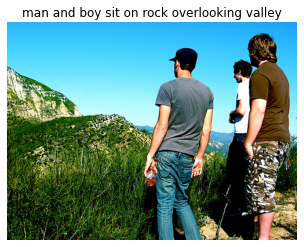

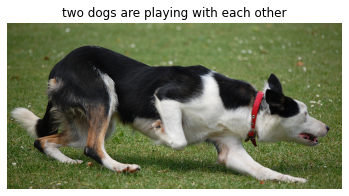

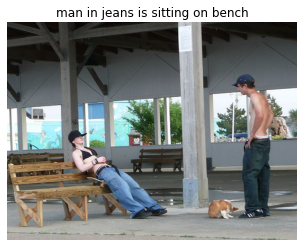

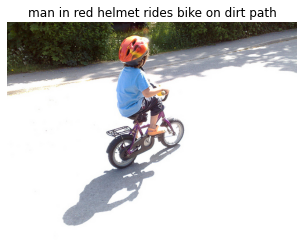

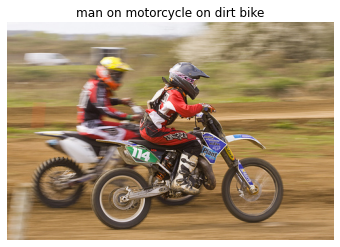

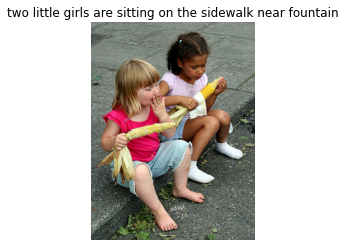

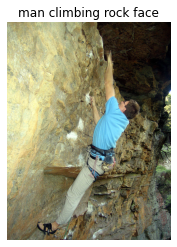

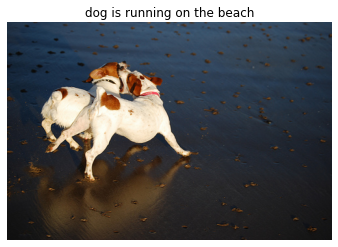

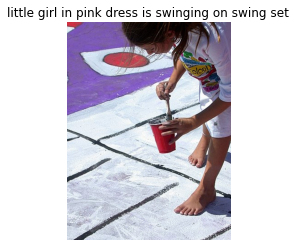

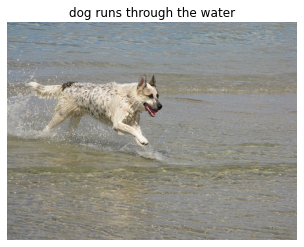

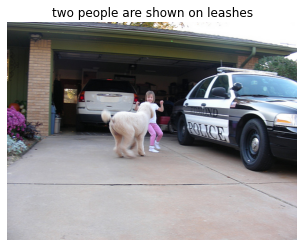

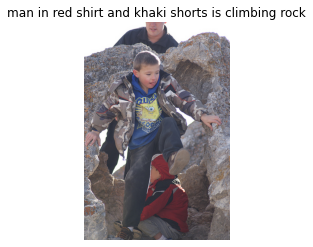

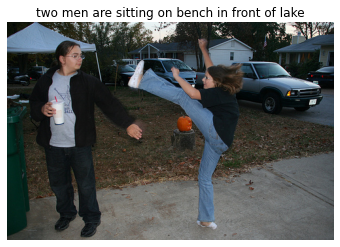

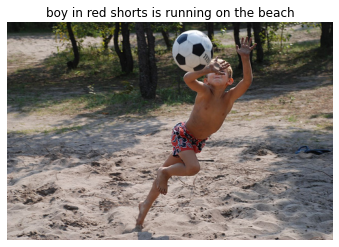

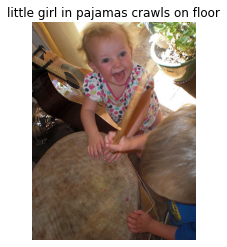

In [75]:
### time to gen pred 
for i in range(15):
  idx = np.random.randint(0,500)
  all_img_name = list(encode_test.keys())
  img_name = all_img_name[idx]
  photo = encode_test[img_name].reshape((1,2048))
  #print(model.predict)
  #print(photo)
  #print(img_name)
  #print(pred(photo))
  

  i = plt.imread('/content/Flickr_Data/Flickr_Data/Images/'+ img_name +'.jpg')
  plt.imshow(i)
  caption = pred(photo)
  plt.title(caption)
  
  plt.axis("off")
  plt.show()